In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_1sec_dhpc_catch'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals =      'dhpcg1','dhpcg20','dhpc24'
pre_animals =      'dhpcg1','dhpcg20','dhpc24'
post_animals =     'dhpcg1','dhpcg20','dhpc24'
pre_rev_animals =  'dhpcg1','dhpcg20','dhpc24'
post_rev_animals = 'dhpcg1','dhpcg20','dhpc24'
catch_animals =    'dhpcg1','dhpcg20'

In [9]:
sessions = 'catch',

In [10]:
for sess in sessions:
    for dur in 1,: #use 5 for 0.5sec, 1 for 1 sec and 2 for 2sec
        exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,dur,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,sess))
        if sess == 'catch':
            exec("labels_catch_nd = dict(zip(%s_animals, [ut.load_variable('labels_%s_nd',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess))

In [11]:
#delta_t0 = 0.5sec
#from referenced notebook, 14 time bins total beginning at 3s prior to odor onset and running through 11s post onset

#t_start0 = -3  # sec
#t_stop0 = 11  # sec

In [7]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None,n_trials=None):
#     which_train = range(90)
#     which_test = range(90)
#    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        if n_trials != None:
            which_train_a = which_train_a[:n_trials]
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        if n_trials != None:
            which_train_b = which_train_b[:n_trials]
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [13]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [14]:
for sess in sessions:
    for t in range(14):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20 catch dhpcg1 catch dhpcg20


In [15]:
all_labels='rwVSsh','rwVScsm','shVScsm','rwndVSshnd','rwVSrwnd','rwndVScsm','shVSshnd','shndVScsm'

In [16]:
relabel_rwVSsh =     {0:-3, 1:1,  2:0,  -1:-1, -2:-2}
relabel_rwVScsm =    {0:0,  1:1,  2:-3, -1:-1, -2:-2}
relabel_shVScsm =    {0:0,  1:-3, 2:1,  -1:-1, -2:-2}
relabel_rwndVSshnd = {0:-3, 1:-3, 2:-3, -1:0,  -2:1}
relabel_rwVSrwnd =   {0:-3, 1:0,  2:-3, -1:1, -2:-2}
relabel_shVSshnd =   {0:-3, 1:-3, 2:0,  -1:-1, -2:1}
relabel_shndVScsm =  {0:0,  1:-3, 2:-3, -1:-1, -2:1} #ndmeans not delivered (as in, US was not delivered)
relabel_rwndVScsm =  {0:0,  1:-3, 2:-3, -1:1,  -2:-2}

for sess in sessions:
    for labels in all_labels:
        exec("labels_%s_%s = {}"%(labels,sess))
        for ani in eval("%s_animals"%sess):
            exec("labels_%s_%s[ani] = np.r_[[relabel_%s[l] for l in labels_%s[ani]]]"%(labels,sess,labels,sess))

#create labels for rewarded(1) and reward_catch(0) (and sh and sh catch) trials. Set opposite US =-1 so deocder ignores
labels_rwVSrwnd_catch={} #rewarded vs reward catch
labels_shVSshnd_catch={} #shocked vs shock catch
labels_rwndVScsm_catch = {} #reward catch vs csm
labels_shndVScsm_catch = {} #shock catch vs csm
labels_rwVScsm_catch = {} ############### GET LABELS FOR THIS AND THE TWO BELOW
labels_shVScsm_catch = {}
labels_rwndVSshnd_catch = {}

for ani in catch_animals:
    labels_rwVSrwnd_catch[ani] = labels_catch[ani].copy()
    labels_shVSshnd_catch[ani] = labels_catch[ani].copy()
    labels_rwndVScsm_catch[ani] = labels_catch[ani].copy()
    labels_shndVScsm_catch[ani] = labels_catch[ani].copy()
    labels_rwVScsm_catch[ani]    = labels_catch[ani].copy()
    labels_shVScsm_catch[ani]    = labels_catch[ani].copy()
    labels_rwndVSshnd_catch[ani] = labels_catch[ani].copy()
    for x in range(len(labels_catch[ani])):
        if labels_catch[ani][x]==0:
            labels_rwVSrwnd_catch[ani][x]=-1
            labels_shVSshnd_catch[ani][x]=-1
            labels_rwndVScsm_catch[ani][x]=0
            labels_shndVScsm_catch[ani][x]=0
            labels_rwVScsm_catch[ani][x]=0   
            labels_shVScsm_catch[ani][x]= 0  
            labels_rwndVSshnd_catch[ani][x]=-1
        if labels_catch[ani][x]==1:
            labels_rwVSrwnd_catch[ani][x]= 1
            labels_shVSshnd_catch[ani][x]=-1
            labels_rwndVScsm_catch[ani][x]=-1
            labels_shndVScsm_catch[ani][x]=-1
            labels_rwVScsm_catch[ani][x]= 1  
            labels_shVScsm_catch[ani][x]= -1  
            labels_rwndVSshnd_catch[ani][x]=-1
        if labels_catch[ani][x]==2:
            labels_rwVSrwnd_catch[ani][x]=-1
            labels_shVSshnd_catch[ani][x]=1
            labels_rwndVScsm_catch[ani][x]=-1
            labels_shndVScsm_catch[ani][x]=-1
            labels_rwVScsm_catch[ani][x]= -1  
            labels_shVScsm_catch[ani][x]= 1  
            labels_rwndVSshnd_catch[ani][x]=-1
        if labels_catch_nd[ani][x] ==1:
            labels_rwVSrwnd_catch[ani][x]=0
            labels_shVSshnd_catch[ani][x]=-1
            labels_rwndVScsm_catch[ani][x]=1
            labels_shndVScsm_catch[ani][x]=-1
            labels_rwVScsm_catch[ani][x]= -1  
            labels_shVScsm_catch[ani][x]=  -1
            labels_rwndVSshnd_catch[ani][x]= 1
        if labels_catch_nd[ani][x] ==2:
            labels_rwVSrwnd_catch[ani][x]=-1
            labels_shVSshnd_catch[ani][x]=0
            labels_rwndVScsm_catch[ani][x]=-1
            labels_shndVScsm_catch[ani][x]=1
            labels_rwVScsm_catch[ani][x]= -1
            labels_shVScsm_catch[ani][x]= -1
            labels_rwndVSshnd_catch[ani][x]=0

In [17]:
%%time
for t in range(14): # number of time bins
    exec('scores_tb_%s = {}'%t)
    n_loops = 15
    for label in all_labels:
        print label,
        print t,
        eval("scores_tb_%s"%t)[label] = np.r_[[do_test_within(eval('patterns_tb_%s_catch'%(t)),eval('labels_%s_%s'%(label,sess))) for i in range(n_loops)]]

rwVSsh 0 rwVScsm 0 shVScsm 0 rwndVSshnd 0 rwVSrwnd 0 rwndVScsm 0 shVSshnd 0 shndVScsm 0 rwVSsh 1 rwVScsm 1 shVScsm 1 rwndVSshnd 1 rwVSrwnd 1 rwndVScsm 1 shVSshnd 1 shndVScsm 1 rwVSsh 2 rwVScsm 2 shVScsm 2 rwndVSshnd 2 rwVSrwnd 2 rwndVScsm 2 shVSshnd 2 shndVScsm 2 rwVSsh 3 rwVScsm 3 shVScsm 3 rwndVSshnd 3 rwVSrwnd 3 rwndVScsm 3 shVSshnd 3 shndVScsm 3 rwVSsh 4 rwVScsm 4 shVScsm 4 rwndVSshnd 4 rwVSrwnd 4 rwndVScsm 4 shVSshnd 4 shndVScsm 4 rwVSsh 5 rwVScsm 5 shVScsm 5 rwndVSshnd 5 rwVSrwnd 5 rwndVScsm 5 shVSshnd 5 shndVScsm 5 rwVSsh 6 rwVScsm 6 shVScsm 6 rwndVSshnd 6 rwVSrwnd 6 rwndVScsm 6 shVSshnd 6 shndVScsm 6 rwVSsh 7 rwVScsm 7 shVScsm 7 rwndVSshnd 7 rwVSrwnd 7 rwndVScsm 7 shVSshnd 7 shndVScsm 7 rwVSsh 8 rwVScsm 8 shVScsm 8 rwndVSshnd 8 rwVSrwnd 8 rwndVScsm 8 shVSshnd 8 shndVScsm 8 rwVSsh 9 rwVScsm 9 shVScsm 9 rwndVSshnd 9 rwVSrwnd 9 rwndVScsm 9 shVSshnd 9 shndVScsm 9 rwVSsh 10 rwVScsm 10 shVScsm 10 rwndVSshnd 10 rwVSrwnd 10 rwndVScsm 10 shVSshnd 10 shndVScsm 10 rwVSsh 11 rwVScsm 11 shV

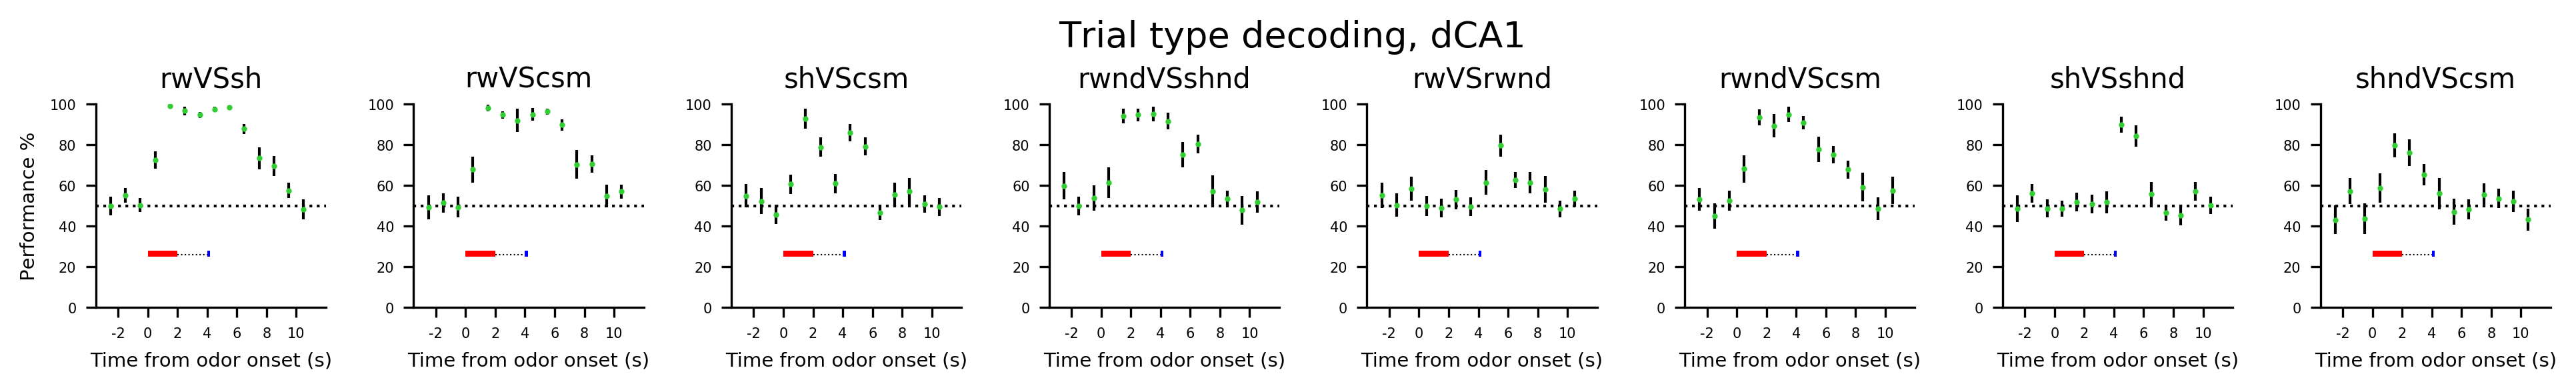

In [18]:
fig, ax = pl.subplots(1,len(all_labels), figsize=(13, 1.8))

for label,col in zip(all_labels,range(len(all_labels))):
    for t in range(14):
        ax[col].plot(t-2.5, np.mean(eval("scores_tb_%s[label]"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(eval("scores_tb_%s[label]"%t))*100
        s = np.std(eval("scores_tb_%s[label]"%t))*100 / np.sqrt(eval("scores_tb_%s[label]"%t).shape[-1])
        ax[col].errorbar(t-2.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col].set_title(all_labels[col],fontsize=10)
for x in range (len(all_labels)):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-3.5, 12)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50,-3.5,12, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[0].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle("Trial type decoding, dCA1", y=1.05,fontsize=13)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_horizontal.jpg'%NOTEBOOK_NAME)

In [19]:
labels_to_plot = [1,5,4,2,7,6]
labels_to_label = ['rw VS CS-','rw catch VS CS-','rw catch VS rw','sh VS CS-','sh catch VS CS-','sh catch vs sh']

Error signal in CA1?
n trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-


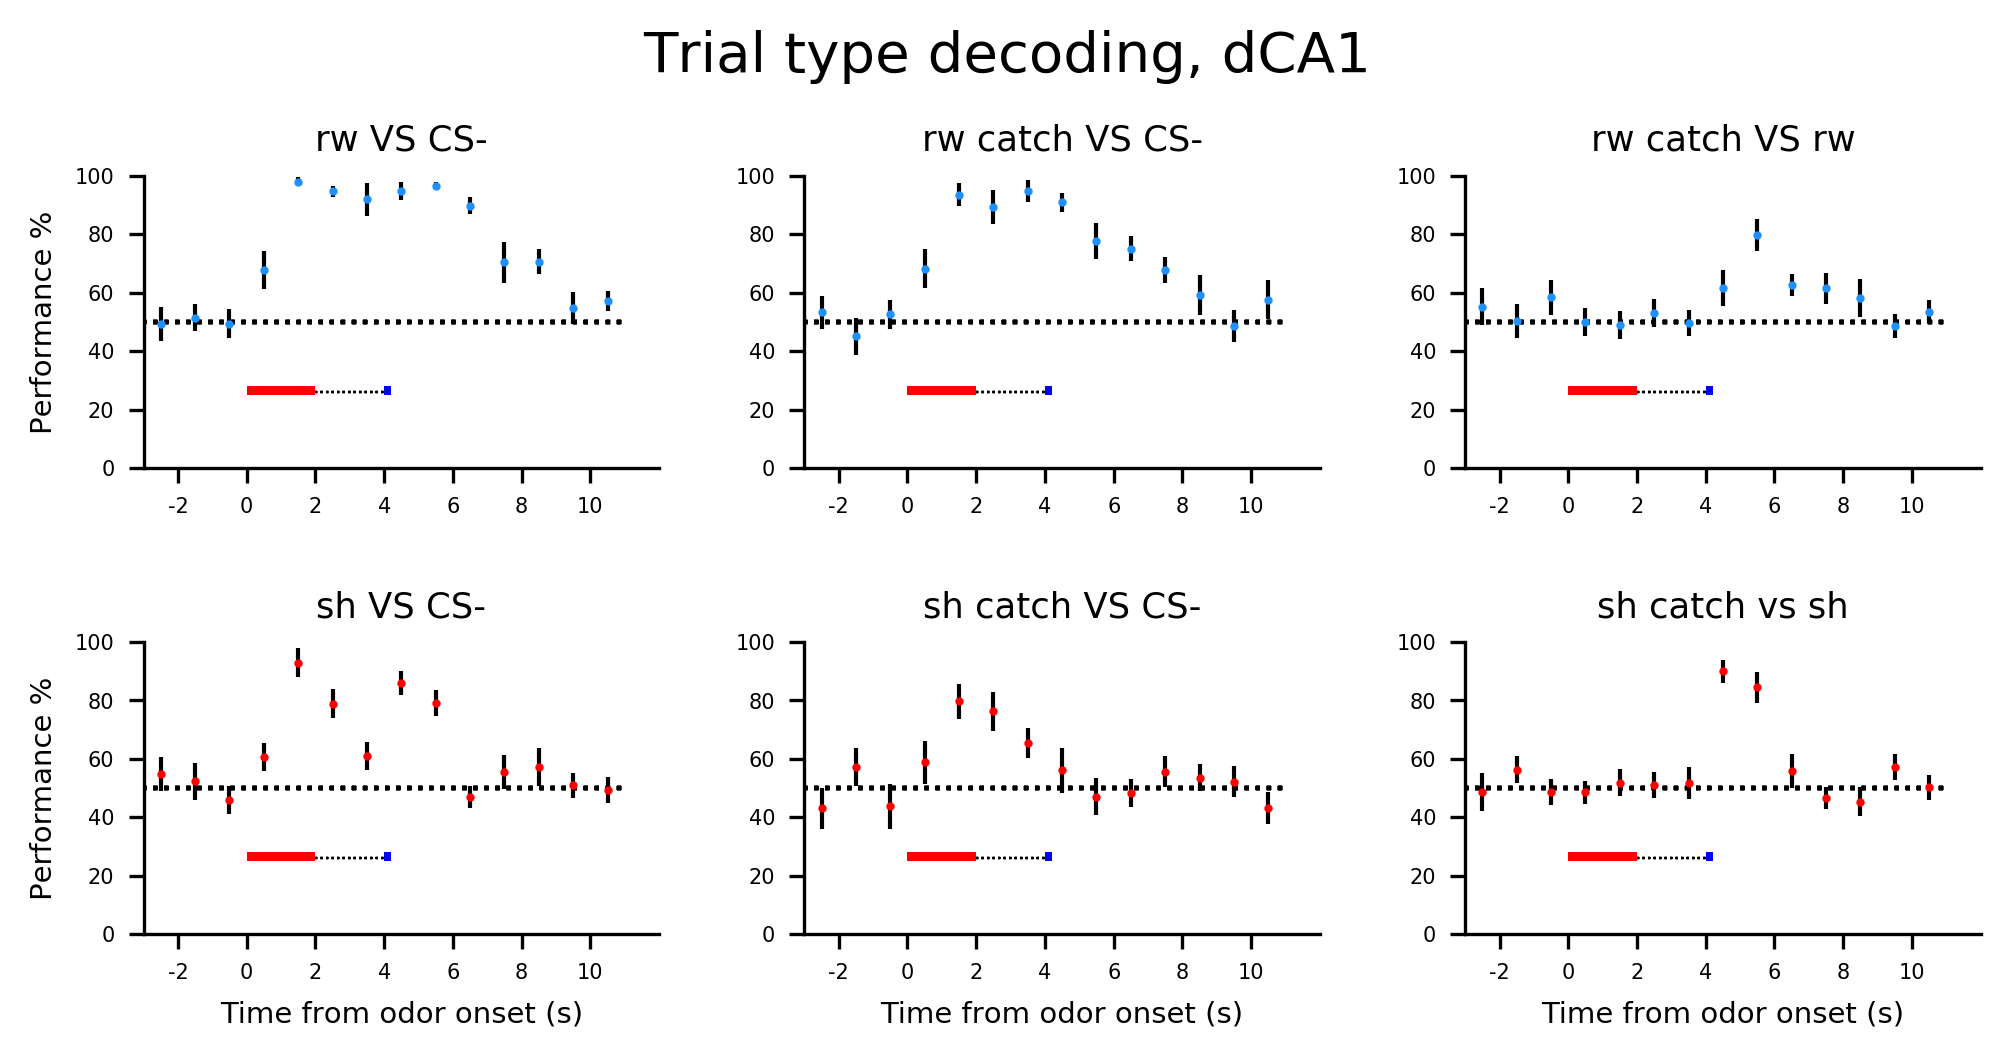

In [20]:
fig, ax = pl.subplots(2,3, figsize=(7, 3.5))

colors =['dodgerblue','r']
i=-1
for r in range(2):
    for c in range(3):
        i=i+1
        for t in range(14):
            ax[r][c].plot(t-2.5, np.mean(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
            m = np.mean(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100
            s = np.std(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100 / np.sqrt(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])).shape[-1])
            ax[r][c].errorbar(t-2.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            ax[r][c].set_title(labels_to_label[i],fontsize=8.5)
            ax[r][c].set_ylim(0, 100)
            ax[r][c].set_xlim(-3, 12)
            ax[r][c].set_xticks(np.arange(-2,11, 2))
            ax[r][c].set_xticklabels(np.arange(-2,11, 2))
            ax[r][c].hlines(50,-4,11, color='k', lw=1, linestyles='dotted')
            ax[1][c].set_xlabel('Time from odor onset (s)')
            ax[r][0].set_ylabel('Performance %')
            pt.plot_period_bar(ax[r][c], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[r][c], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[r][c].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle('Trial type decoding, dCA1',y=1.02,fontsize=13.5)

fig.tight_layout(pad=3.5)
print 'Error signal in CA1?\nn trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-'

fig.savefig('../img/%s_just_catch.jpg'%NOTEBOOK_NAME)

Error signal in CA1?
n trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-


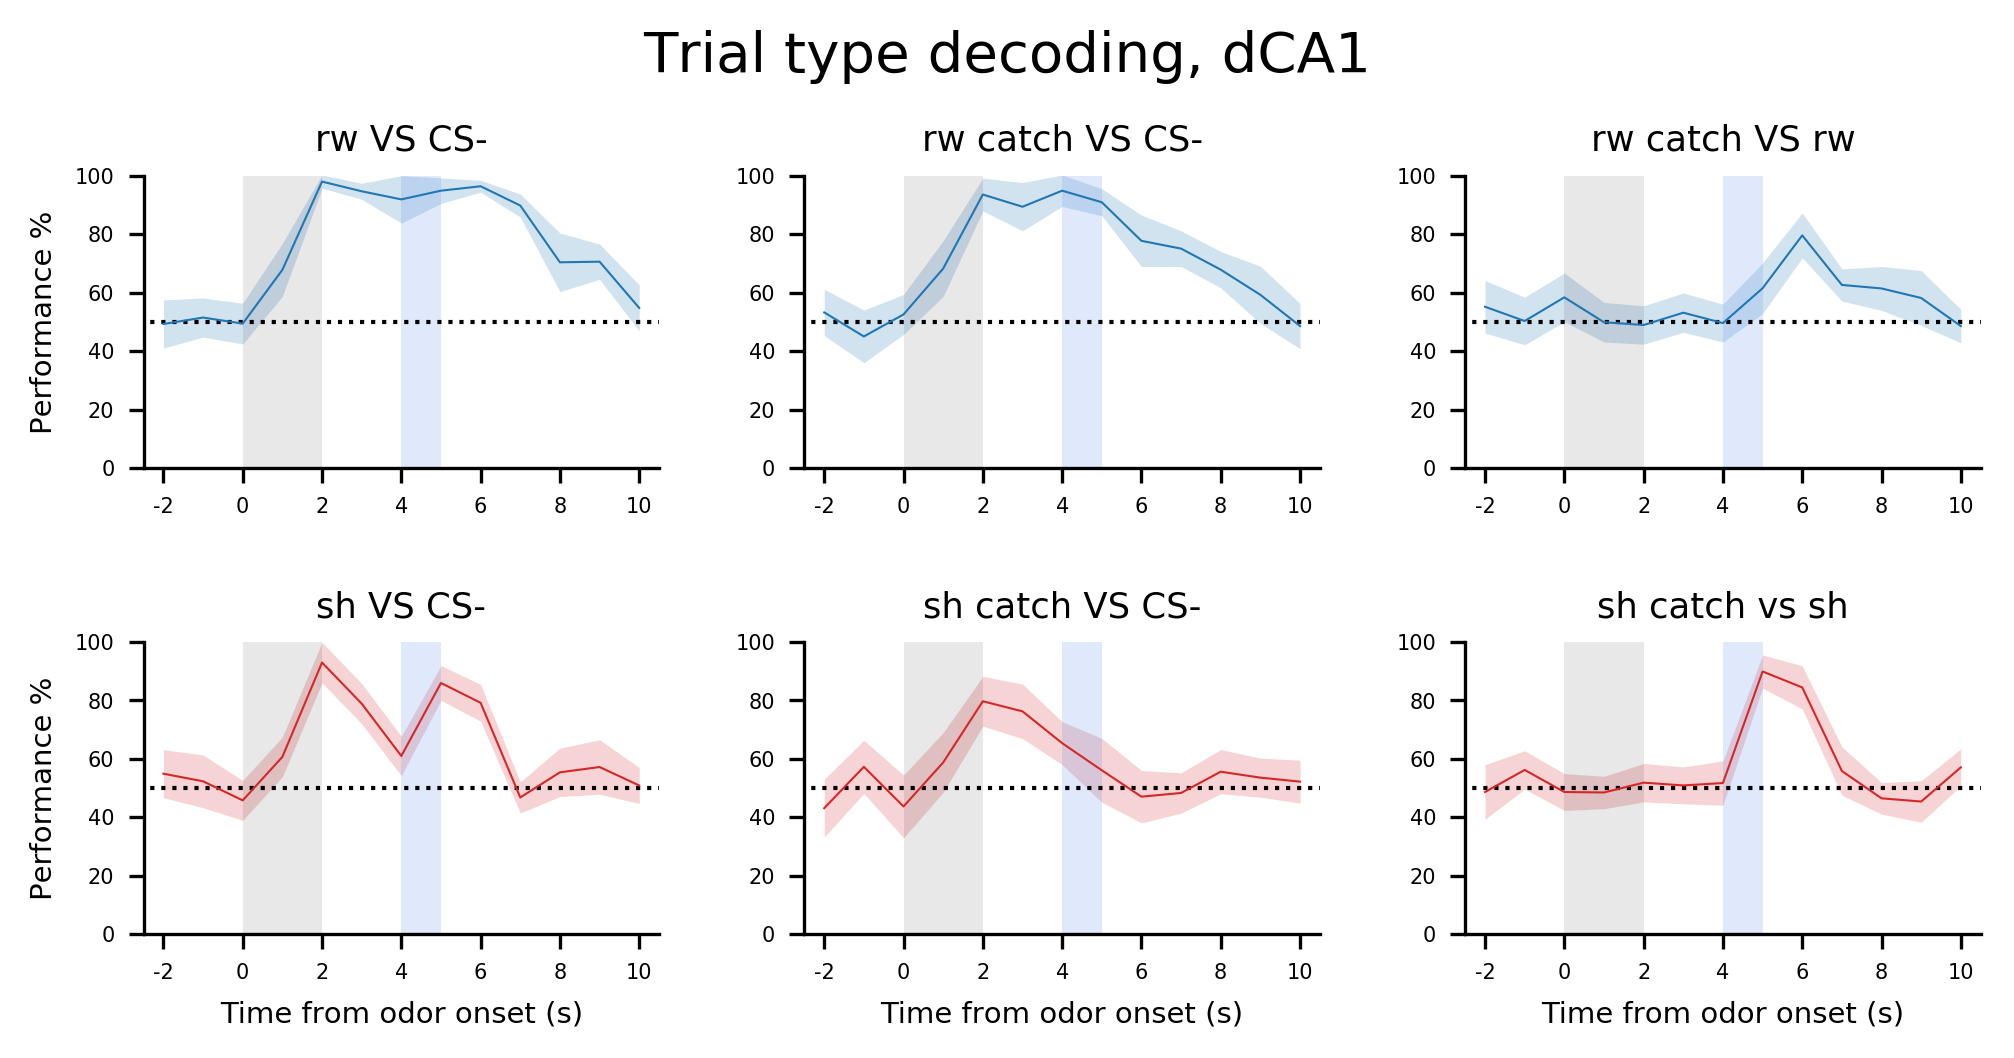

In [21]:
fig, ax = pl.subplots(2,3, figsize=(7, 3.5))

colors =['tab:blue','tab:red']
i=-1
for r in range(2):
    for c in range(3):
        i=i+1
        ax[r][c].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100) for t in range(13)], color=colors[r], ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s['%s']"%(t,all_labels[labels_to_plot[i]])))*100 for t in range(13)])
        ax[r][c].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=colors[r],linewidth=0)
        ax[r][c].set_title(labels_to_label[i],fontsize=8.5)
        ax[r][c].set_ylim(0, 100)
        ax[r][c].set_xlim(-2.5, 10.5)
        ax[r][c].set_xticks(np.arange(-2,11, 2))
        ax[r][c].set_xticklabels(np.arange(-2,11, 2))
        ax[r][c].hlines(50,-4,11, color='k', lw=1, linestyles='dotted')
        ax[1][c].set_xlabel('Time from odor onset (s)')
        ax[r][0].set_ylabel('Performance %')
        pt.plot_period_bar(ax[r][c], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[r][c], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[r][c].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle('Trial type decoding, dCA1',y=1.02,fontsize=13.5)

fig.tight_layout(pad=3.5)
print 'Error signal in CA1?\nn trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-'

fig.savefig('../img/%s_just_catch.jpg'%NOTEBOOK_NAME)

### now look at when the number of trials are equalized across trial types

In [22]:
%%time
# now make the number of trials for each trial type equal by restricting each trial type to the lowest occuring type (n=15)
# to do this, set n_trials=15 in fxn
for t in range(14): # number of time bins
    exec('scores_tb_%s_equal_trials = {}'%t)
    n_loops = 50
    for label in all_labels:
        print label,
        print t,
        eval("scores_tb_%s_equal_trials"%t)[label] = np.r_[[do_test_within(eval('patterns_tb_%s_catch'%(t)),eval('labels_%s_%s'%(label,sess)),n_trials=15) for i in range(n_loops)]]

rwVSsh 0 rwVScsm 0 shVScsm 0 rwndVSshnd 0 rwVSrwnd 0 rwndVScsm 0 shVSshnd 0 shndVScsm 0 rwVSsh 1 rwVScsm 1 shVScsm 1 rwndVSshnd 1 rwVSrwnd 1 rwndVScsm 1 shVSshnd 1 shndVScsm 1 rwVSsh 2 rwVScsm 2 shVScsm 2 rwndVSshnd 2 rwVSrwnd 2 rwndVScsm 2 shVSshnd 2 shndVScsm 2 rwVSsh 3 rwVScsm 3 shVScsm 3 rwndVSshnd 3 rwVSrwnd 3 rwndVScsm 3 shVSshnd 3 shndVScsm 3 rwVSsh 4 rwVScsm 4 shVScsm 4 rwndVSshnd 4 rwVSrwnd 4 rwndVScsm 4 shVSshnd 4 shndVScsm 4 rwVSsh 5 rwVScsm 5 shVScsm 5 rwndVSshnd 5 rwVSrwnd 5 rwndVScsm 5 shVSshnd 5 shndVScsm 5 rwVSsh 6 rwVScsm 6 shVScsm 6 rwndVSshnd 6 rwVSrwnd 6 rwndVScsm 6 shVSshnd 6 shndVScsm 6 rwVSsh 7 rwVScsm 7 shVScsm 7 rwndVSshnd 7 rwVSrwnd 7 rwndVScsm 7 shVSshnd 7 shndVScsm 7 rwVSsh 8 rwVScsm 8 shVScsm 8 rwndVSshnd 8 rwVSrwnd 8 rwndVScsm 8 shVSshnd 8 shndVScsm 8 rwVSsh 9 rwVScsm 9 shVScsm 9 rwndVSshnd 9 rwVSrwnd 9 rwndVScsm 9 shVSshnd 9 shndVScsm 9 rwVSsh 10 rwVScsm 10 shVScsm 10 rwndVSshnd 10 rwVSrwnd 10 rwndVScsm 10 shVSshnd 10 shndVScsm 10 rwVSsh 11 rwVScsm 11 shV

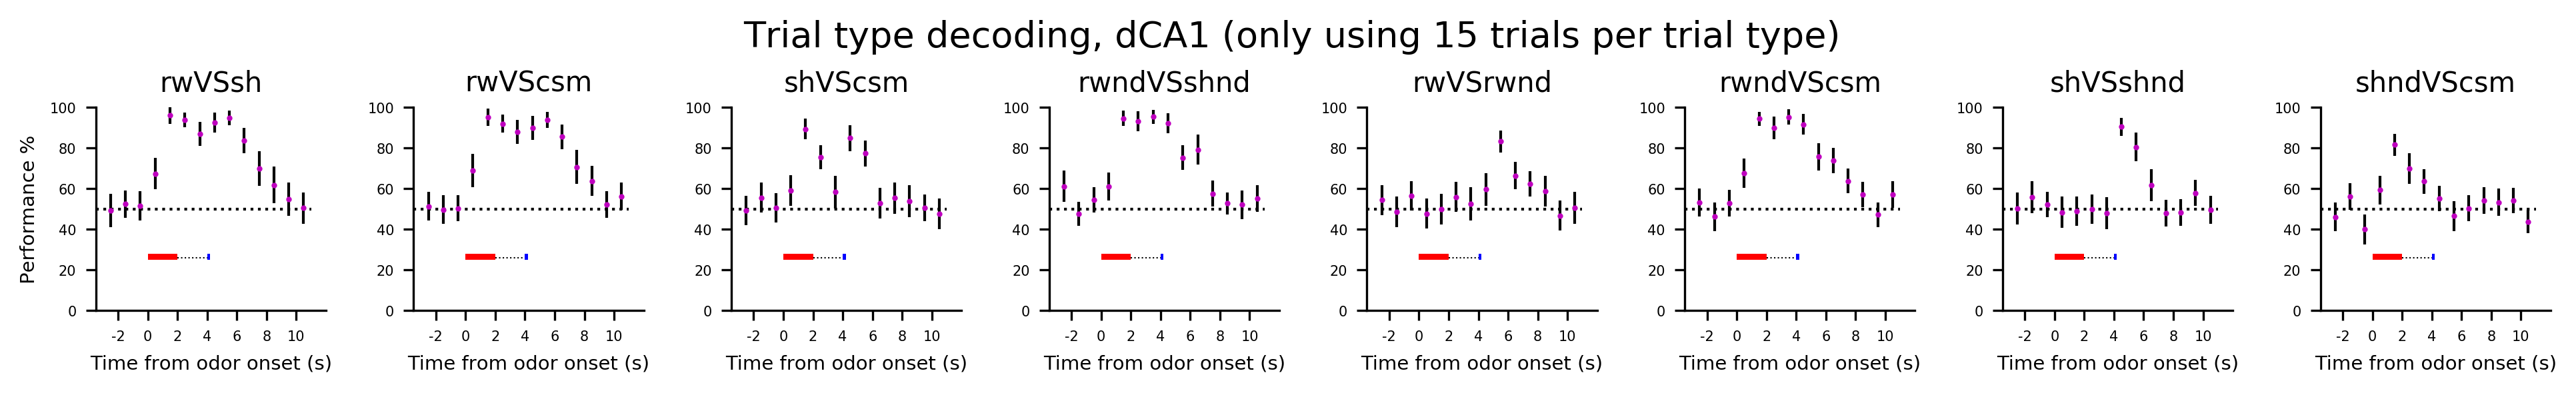

In [23]:
fig, ax = pl.subplots(1,len(all_labels), figsize=(13, 1.8))

for label,col in zip(all_labels,range(len(all_labels))):
    for t in range(14):
        ax[col].plot(t-2.5, np.mean(eval("scores_tb_%s_equal_trials[label]"%t))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(eval("scores_tb_%s_equal_trials[label]"%t))*100
        s = np.std(eval("scores_tb_%s_equal_trials[label]"%t))*100 / np.sqrt(eval("scores_tb_%s_equal_trials[label]"%t).shape[-1])
        ax[col].errorbar(t-2.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[col].set_title(all_labels[col],fontsize=10)
for x in range (len(all_labels)):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-3.5, 12)
    ax[x].set_xticks(np.arange(-2,12, 2))
    ax[x].set_xticklabels(np.arange(-2,12, 2))
    ax[x].hlines(50,-3.5,11, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[0].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle("Trial type decoding, dCA1 (only using 15 trials per trial type)", y=1.06,fontsize=13)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_horizontal.jpg'%NOTEBOOK_NAME)

Error signal in CA1?
n trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-


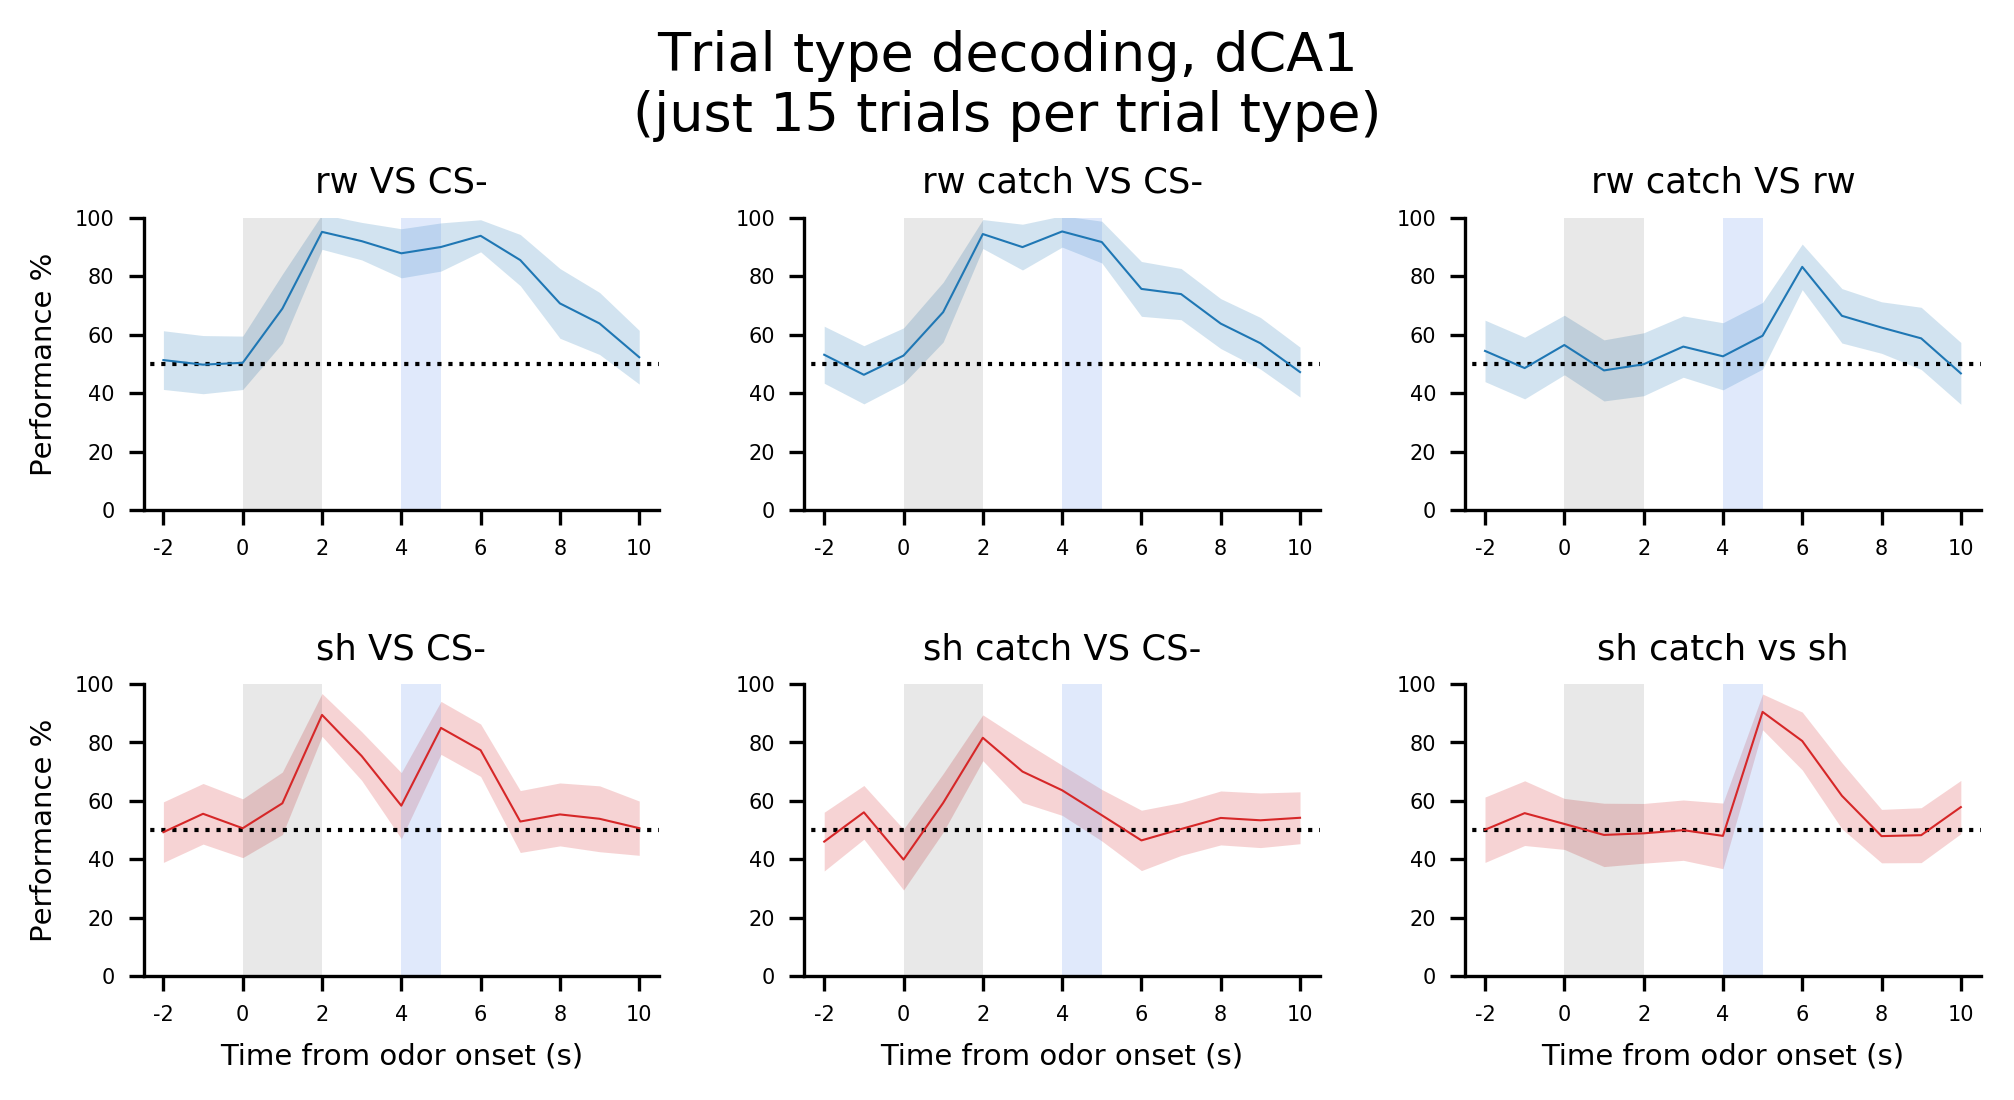

In [24]:
fig, ax = pl.subplots(2,3, figsize=(7, 3.5))

colors =['tab:blue','tab:red']
i=-1
for r in range(2):
    for c in range(3):
        i=i+1
        ax[r][c].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s_equal_trials['%s']"%(t,all_labels[labels_to_plot[i]])))*100) for t in range(13)], color=colors[r], ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s_equal_trials['%s']"%(t,all_labels[labels_to_plot[i]])))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s_equal_trials['%s']"%(t,all_labels[labels_to_plot[i]])))*100 for t in range(13)])
        ax[r][c].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=colors[r],linewidth=0)
        ax[r][c].set_title(labels_to_label[i],fontsize=8.5)
        ax[r][c].set_ylim(0, 100)
        ax[r][c].set_xlim(-2.5, 10.5)
        ax[r][c].set_xticks(np.arange(-2,11, 2))
        ax[r][c].set_xticklabels(np.arange(-2,11, 2))
        ax[r][c].hlines(50,-4,11, color='k', lw=1, linestyles='dotted')
        ax[1][c].set_xlabel('Time from odor onset (s)')
        ax[r][0].set_ylabel('Performance %')
        pt.plot_period_bar(ax[r][c], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[r][c], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[r][c].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle('Trial type decoding, dCA1\n(just 15 trials per trial type)',y=1.06,fontsize=13)

fig.tight_layout(pad=3.5)
print 'Error signal in CA1?\nn trials = 45 sh, 45 rw, 15 sh catch, 15 rw catch, 20 CS-'

fig.savefig('../img/%s_just_catch_equal_trials.jpg'%NOTEBOOK_NAME)

In [8]:
total_cells_catch_dhpc = 0
for ani in catch_animals:
    print patterns_tb_0_catch[ani].shape[-1]
    total_cells_catch_dhpc = total_cells_catch_dhpc + patterns_tb_0_catch[ani].shape[-1]
print total_cells_catch_dhpc

181
173
354


In [26]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
